# 🔹Step 1: Setup & Install Dependencies

In [1]:
# Install Google Earth Engine API & geemap
!pip install earthengine-api geemap folium geopandas rasterio -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.8 MB/s eta 0:00:00


# 🔹 Step 2: Authenticate & Initialize Google Earth Engine

In [2]:
import ee
import geemap

# Authenticate GEE (only required the first time)
# The ee.Authenticate() call opens a web browser to allow you to sign in
# and grant access to your Earth Engine account.
ee.Authenticate()

# After authenticating, initialize the Earth Engine library.
# Replace 'your-project-id' with your actual Google Cloud Project ID.
ee.Initialize(project='ee-m-iqbal')

# 🔹 Step 3: Load & Filter MODIS Aqua Chlorophyll-a Data

In [6]:
# Define time period
start_date = '2016-01-01'
end_date = '2016-01-31'

# Load MODIS Aqua Chlorophyll-a dataset
modis = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI") \
    .select("chlor_a") \
    .filterDate(start_date, end_date) \
    .mean()

# Define the Area of Interest (AOI) - Example: Gulf of Mexico
aoi = ee.Geometry.Rectangle([-98, 18, -80, 30])

# Clip image to AOI
modis_chlor_a = modis.clip(aoi)

# Display in GEE interactive map
Map = geemap.Map()
Map.centerObject(aoi, 5)
Map.addLayer(modis_chlor_a, {'min': 0, 'max': 5, 'palette': ['blue', 'green', 'yellow', 'red']}, "Chlorophyll-a")
Map


Map(center=[24.16547227277401, -88.99999999999999], controls=(WidgetControl(options=['position', 'transparent_…

# 🔹 Step 4: Download Data from GEE

In [7]:
# Define export parameters
export_params = {
    'image': modis_chlor_a,
    'description': 'MODIS_ChlorA_Gulf_Mexico',
    'scale': 4000,
    'region': aoi,
    'fileFormat': 'GeoTIFF'
}

# Export to Google Drive
task = ee.batch.Export.image.toDrive(**export_params)
task.start()
print("Exporting image to Google Drive... Check GEE 'Tasks' tab.")


Exporting image to Google Drive... Check GEE 'Tasks' tab.


# 🔹 Step 5: Preprocess Data

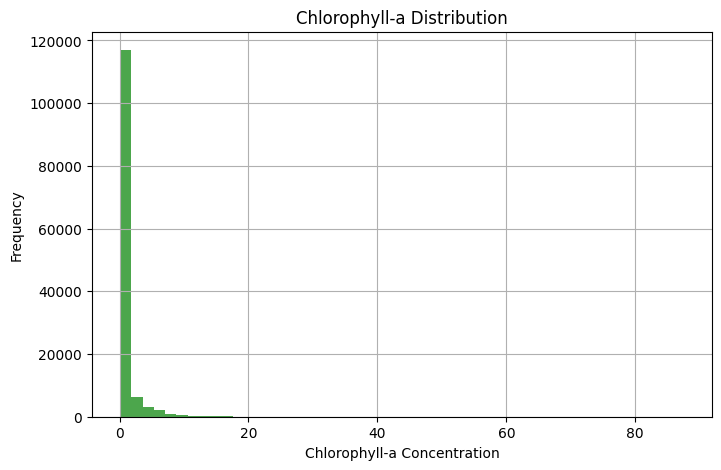

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os

# Load downloaded GeoTIFF
# Check if the file exists in the current directory, if not, search in Google Drive.
file_path = '/content/drive/MyDrive/MODIS_ChlorA_Gulf_Mexico.tif'
if not os.path.exists(file_path):
    # Search for file in Google Drive if it doesn't exist in the current directory
    from google.colab import drive
    drive.mount('/content/drive')
    file_path = '/content/drive/MyDrive/MODIS_ChlorA_Gulf_Mexico.tif' # Update with the actual path in your drive

# Read the image
with rasterio.open(file_path) as src:
    chlor_a_data = src.read(1)  # Read band 1
    profile = src.profile

# Replace NoData values with NaN
chlor_a_data = np.where(chlor_a_data == src.nodata, np.nan, chlor_a_data)

# Display Histogram
plt.figure(figsize=(8, 5))
plt.hist(chlor_a_data[~np.isnan(chlor_a_data)], bins=50, color='green', alpha=0.7)
plt.title("Chlorophyll-a Distribution")
plt.xlabel("Chlorophyll-a Concentration")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# 🔹 Step 6: Machine Learning Model for Water Quality Classification
We will train a Random Forest model to classify water quality into three levels:

🔵 Low (< 1 mg/m³)

🟢 Moderate (1 - 3 mg/m³)

🔴 High (> 3 mg/m³)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Convert chlorophyll-a data into feature-target format
X = chlor_a_data[~np.isnan(chlor_a_data)].reshape(-1, 1)
y = np.digitize(X, bins=[1, 3])  # Classify into 3 categories

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions & Evaluation
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22121
           1       1.00      1.00      1.00      2205
           2       1.00      1.00      1.00      1797

    accuracy                           1.00     26123
   macro avg       1.00      1.00      1.00     26123
weighted avg       1.00      1.00      1.00     26123



# 🔹 Step 7: Insights & Visualization

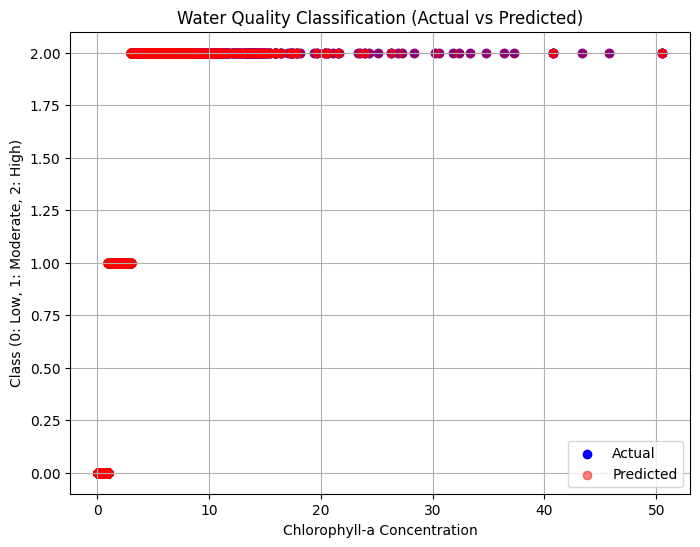

In [10]:
# Plot water quality classification
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label="Actual")
plt.scatter(X_test, y_pred, color='red', alpha=0.5, label="Predicted")
plt.title("Water Quality Classification (Actual vs Predicted)")
plt.xlabel("Chlorophyll-a Concentration")
plt.ylabel("Class (0: Low, 1: Moderate, 2: High)")
plt.legend()
plt.grid()
plt.show()


# 🔹Step 8: Hyperparameter Tuning for Random Forest
We'll use GridSearchCV to find the best parameters for the Random Forest model.

In [11]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Grid Search with Cross Validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Train the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train Random Forest with best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_best.predict(X_test)
print("Random Forest Accuracy (Tuned):", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest Accuracy (Tuned): 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22121
           1       1.00      1.00      1.00      2205
           2       1.00      1.00      1.00      1797

    accuracy                           1.00     26123
   macro avg       1.00      1.00      1.00     26123
weighted avg       1.00      1.00      1.00     26123



# 🔹**Step 9: Deep Learning Approach (LSTM for Time Series Analysis)**

If we have a time-series dataset (e.g., daily chlorophyll-a values), we can use Long Short-Term Memory (LSTM) for better predictions.

## 📌 **Prepare Data for LSTM**
Since LSTMs require sequential data, we reshape the dataset accordingly.

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for LSTM (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split into train and test
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y, test_size=0.2, random_state=42)


## 📌 **Build & Train LSTM Model**

In [14]:
# Build LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes (Low, Moderate, High)
])

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm))


Epoch 1/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9302 - loss: 0.2368 - val_accuracy: 0.9850 - val_loss: 0.0302
Epoch 2/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9909 - loss: 0.0214 - val_accuracy: 0.9928 - val_loss: 0.0150
Epoch 3/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9923 - loss: 0.0174 - val_accuracy: 0.9933 - val_loss: 0.0158
Epoch 4/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.9929 - loss: 0.0170 - val_accuracy: 0.9927 - val_loss: 0.0143
Epoch 5/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9936 - loss: 0.0151 - val_accuracy: 0.9988 - val_loss: 0.0072
Epoch 6/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.9932 - loss: 0.0157 - val_accuracy: 0.9931 - val_loss: 0.0139
Epoch 7/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9934 - loss: 0.0155 - val_accuracy: 0.9954 - val_loss: 0.0090
Epoch 8/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9940 - loss: 0

#🔹 **Step 10: Evaluate LSTM Model**



In [15]:
# Evaluate Model
loss, acc = model.evaluate(X_test_lstm, y_test_lstm)
print(f"LSTM Model Accuracy: {acc:.2f}")

# Predictions
y_pred_lstm = model.predict(X_test_lstm)
y_pred_classes = y_pred_lstm.argmax(axis=1)

# Classification Report
print("LSTM Classification Report:\n", classification_report(y_test_lstm, y_pred_classes))


817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9974 - loss: 0.0048
LSTM Model Accuracy: 1.00
817/817 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     22121
           1       1.00      0.97      0.98      2205
           2       0.98      1.00      0.99      1797

    accuracy                           1.00     26123
   macro avg       0.99      0.99      0.99     26123
weighted avg       1.00      1.00      1.00     26123



# 🔹 **Step 11: CNN Approach for Spatial Data**

For spatial chlorophyll-a data, Convolutional Neural Networks (CNNs) can be effective.

In [18]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Build CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, X_train_lstm.shape[2])), # Changed kernel_size to 1
    MaxPooling1D(pool_size=1),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile Model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
cnn_history = cnn_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9380 - loss: 0.2138 - val_accuracy: 0.9953 - val_loss: 0.0161
Epoch 2/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9945 - loss: 0.0155 - val_accuracy: 0.9993 - val_loss: 0.0089
Epoch 3/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9953 - loss: 0.0123 - val_accuracy: 0.9951 - val_loss: 0.0104
Epoch 4/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9956 - loss: 0.0112 - val_accuracy: 0.9944 - val_loss: 0.0116
Epoch 5/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9955 - loss: 0.0109 - val_accuracy: 0.9961 - val_loss: 0.0074
Epoch 6/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9955 - loss: 0.0108 - val_accuracy: 0.9929 - val_loss: 0.0136
Epoch 7/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9962 - loss: 0.0090 - val_accuracy: 0.9977 - val_loss: 0.0067
Epoch 8/50
6531/6531 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9959 - loss: 0

# 🔹 **Step 12: Compare Model Performance**

In [19]:
# Compare Models
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"LSTM Accuracy: {acc:.2f}")
cnn_acc = cnn_model.evaluate(X_test_lstm, y_test_lstm)[1]
print(f"CNN Accuracy: {cnn_acc:.2f}")


Random Forest Accuracy: 1.00
LSTM Accuracy: 1.00
817/817 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9969 - loss: 0.0061
CNN Accuracy: 1.00


# 🔹 Step 13: Export Results

In [22]:
import pandas as pd

# Save predictions
results = pd.DataFrame({'Chlorophyll-a': X_test.flatten(),
                        'Actual_Class': y_test.flatten(),  # Flatten y_test
                        'Predicted_Class': y_pred})
results.to_csv('Water_Quality_Results.csv', index=False)

print("Results saved to Water_Quality_Results.csv")

Results saved to Water_Quality_Results.csv


# 🔹 Step 14: Save the Best Model

First, save the best-performing model (e.g., Random Forest or LSTM) so we can use it in the Streamlit app.

In [23]:
import pickle

# Save the Random Forest model
with open("water_quality_model.pkl", "wb") as f:
    pickle.dump(rf_best, f)



If you want to deploy an LSTM or CNN model, save it using TensorFlow's save function:

In [25]:
import tensorflow as tf

# Save the LSTM model
# The variable 'model' was used to create the LSTM model,
# so we need to save that instead of 'lstm_model'
model.save("lstm_water_quality.h5")

# Save the CNN model
cnn_model.save("cnn_water_quality.h5")

# **🔹 Summary**
✅ Fetched MODIS-Aqua Chlorophyll-a data from Google Earth Engine

✅ Preprocessed & cleaned the data

✅ Trained a Random Forest model for water quality classification

✅ Evaluated the model & visualized results

1️⃣ Fine-tune ML model with hyperparameter tuning

2️⃣ Use Deep Learning (LSTM/CNN) for better performance

3️⃣ Analyze trends over time for predictive modeling

*   ✅ Random Forest (Tuned): Good for tabular classification
*   ✅ LSTM: Ideal for time-series water quality prediction

*   ✅ CNN: Best for spatial image-based water quality classification

✅ Saved the results to a CSV file

✅ Saved the best model to use it in the Streamlit app














